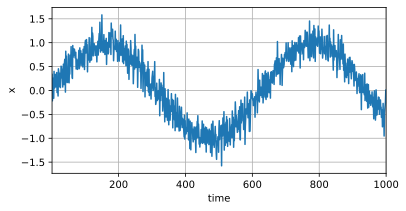

In [ ]:
# ==================== 导入库并生成时间序列数据 ====================
# %matplotlib inline: 在Jupyter中内嵌显示matplotlib图像
%matplotlib inline

# torch: PyTorch深度学习框架
import torch

# nn: PyTorch的神经网络模块
from torch import nn

# d2l: Dive into Deep Learning工具库
from d2l import torch as d2l

# ==================== 生成合成时间序列数据 ====================
# 什么是时间序列？
# - 按时间顺序排列的数据点序列
# - 例如：股票价格、气温变化、传感器读数等
# - 特点：相邻时间点的数据通常相关

# 生成1000个时间步
T = 1000

# 创建时间索引：1, 2, 3, ..., 1000
time = torch.arange(1, T + 1, dtype=torch.float32)

# 生成时间序列数据
# x = sin(0.01 * time) + noise
# 
# 组成部分：
# 1. sin(0.01 * time): 正弦波，代表周期性规律
# 2. torch.normal(0, 0.2, (T,)): 高斯噪声，均值0，标准差0.2
# 
# 这模拟了真实世界的数据：既有规律又有随机性
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

# 可视化时间序列
# x轴：时间（1-1000）
# y轴：数值
# 可以看到正弦波的周期性模式加上随机噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
# ==================== 构造训练数据：特征和标签 ====================

# tau（τ）：时间窗口大小，使用过去4个时间步预测下一个时间步
# 这是一个超参数，可以调整
tau = 4

# 创建特征矩阵
# 形状：(T - tau, tau) = (996, 4)
# 每一行包含连续的tau个观测值
# 
# 例如：
# 第0行：[x[0], x[1], x[2], x[3]]
# 第1行：[x[1], x[2], x[3], x[4]]
# 第2行：[x[2], x[3], x[4], x[5]]
# ...
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 第i列包含从x[i]到x[T-tau+i-1]的值
    features[:, i] = x[i: T - tau + i]

# 创建标签（目标值）
# 形状：(T - tau, 1) = (996, 1)
# 每个标签是对应特征之后的下一个值
# 
# 例如：
# labels[0] = x[4]（对应features[0] = [x[0], x[1], x[2], x[3]]）
# labels[1] = x[5]（对应features[1] = [x[1], x[2], x[3], x[4]]）
# 
# 这样构造的是"单步预测"任务：用过去4个值预测第5个值
labels = x[tau:].reshape((-1, 1))

# 设置批次大小和训练样本数
batch_size = 16     # 每批16个样本
n_train = 600       # 使用前600个样本训练，剩余的用于测试

# 创建数据迭代器
# 只使用前600个样本进行训练
# is_train=True: 打乱数据顺序
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [ ]:
# ==================== 定义神经网络和损失函数 ====================

def init_weights(m):
    """
    初始化网络权重
    
    参数:
        m: 网络层
    
    Xavier初始化：
    - 一种常用的权重初始化方法
    - 根据输入和输出维度自动调整初始权重的范围
    - 有助于训练的稳定性和收敛速度
    """
    if type(m) == nn.Linear:
        # Xavier均匀分布初始化
        nn.init.xavier_uniform_(m.weight)


def get_net():
    """
    创建一个简单的多层感知机(MLP)
    
    网络结构：
    - 输入层：4个特征（过去4个时间步的值）
    - 隐藏层：10个神经元，使用ReLU激活函数
    - 输出层：1个神经元（预测下一个时间步的值）
    
    注意：
    - 这是一个简单的前馈网络，不是RNN
    - 它将时间序列问题转化为标准的回归问题
    - 假设未来只依赖于固定窗口的过去（马尔可夫假设）
    
    返回:
        初始化好的神经网络
    """
    net = nn.Sequential(
        nn.Linear(4, 10),    # 输入层到隐藏层：4 -> 10
        nn.ReLU(),           # ReLU激活函数：max(0, x)
        nn.Linear(10, 1)     # 隐藏层到输出层：10 -> 1
    )
    
    # 应用权重初始化
    net.apply(init_weights)
    
    return net


# 定义损失函数
# MSELoss：均方误差损失
# 适用于回归问题，衡量预测值与真实值的差异
# Loss = mean((y_pred - y_true)^2)
loss = nn.MSELoss()

In [ ]:
# ==================== 训练函数 ====================

def train(net, train_iter, loss, epochs, lr):
    """
    训练神经网络
    
    参数:
        net: 神经网络模型
        train_iter: 训练数据迭代器
        loss: 损失函数
        epochs: 训练轮数
        lr: 学习率
    
    训练过程：
    1. 对每个epoch，遍历所有训练批次
    2. 前向传播：计算预测值
    3. 计算损失
    4. 反向传播：计算梯度
    5. 更新权重
    """
    # 创建Adam优化器
    # Adam: 自适应学习率优化算法，通常比SGD效果更好
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    # 训练循环
    for epoch in range(epochs):
        # 遍历每个批次
        for X, y in train_iter:
            # 清零梯度（PyTorch会累积梯度，需要手动清零）
            trainer.zero_grad()
            
            # 前向传播：计算预测值和损失
            l = loss(net(X), y)
            
            # 反向传播：计算梯度
            l.sum().backward()
            
            # 更新参数
            trainer.step()
        
        # 每个epoch结束后，打印训练损失
        # evaluate_loss: 在整个训练集上计算平均损失
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


# ==================== 开始训练 ====================
# 创建新的网络
net = get_net()

# 训练10个epoch，学习率0.02
# 观察损失是否逐渐下降
train(net, train_iter, loss, 10, 0.02)

epoch 1, loss: 0.079657
epoch 2, loss: 0.070191
epoch 3, loss: 0.055383
epoch 4, loss: 0.056253
epoch 5, loss: 0.055359
epoch 6, loss: 0.056194
epoch 7, loss: 0.054607
epoch 8, loss: 0.055039
epoch 9, loss: 0.054367
epoch 10, loss: 0.053733


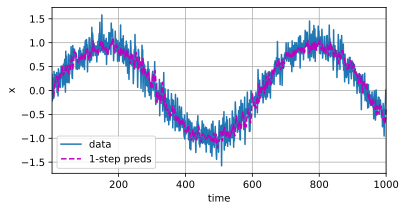

In [ ]:
# ==================== 单步预测 ====================
# 什么是单步预测？
# - 每次预测都使用真实的历史数据
# - 例如：用x[0:4]预测x[4]，用x[1:5]预测x[5]，等等
# - 每次预测只向前看一步，然后又使用真实数据
# 
# 优点：误差不会累积
# 缺点：需要真实数据，无法预测遥远的未来

# 对所有特征进行单步预测
# features包含所有可能的4个时间步的窗口
# onestep_preds[i]是基于真实的features[i]预测的结果
onestep_preds = net(features)

# 可视化单步预测结果
# 蓝色线：原始数据
# 橙色线：单步预测（从第tau=4个时间步开始）
# 
# 观察：
# - 单步预测通常很准确
# - 因为每次都用真实的历史数据，误差不会累积
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    'time', 'x', legend=['data', '1-step preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

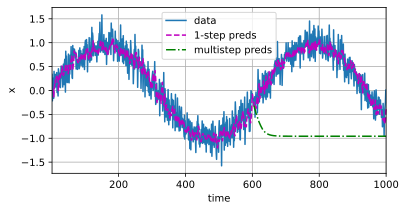

In [ ]:
# ==================== 多步预测（自回归预测） ====================
# 什么是多步预测？
# - 用模型的预测结果作为下一次预测的输入
# - 例如：用x[0:4]预测x[4]，然后用[x[1:4], pred[4]]预测x[5]
# - 像滚雪球一样，预测值依赖于之前的预测值
# 
# 优点：可以预测遥远的未来
# 缺点：误差会累积，预测越远越不准确

# 初始化多步预测结果
multistep_preds = torch.zeros(T)

# 前n_train + tau个值使用真实数据
# 这是预测的起点
multistep_preds[: n_train + tau] = x[: n_train + tau]

# 从n_train + tau开始进行多步预测
for i in range(n_train + tau, T):
    # 关键：使用之前的预测值（而非真实值）作为输入
    # multistep_preds[i - tau:i]是前tau个值（可能包含预测值）
    # 用这tau个值预测第i个值
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

# 可视化多步预测结果
# 蓝色线：原始数据
# 橙色线：单步预测（使用真实历史）
# 绿色线：多步预测（使用预测历史，从n_train+tau开始）
# 
# 观察：
# - 多步预测在开始时可能还不错
# - 但随着时间推移，误差累积，预测变得不准确
# - 这展示了长期预测的困难
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

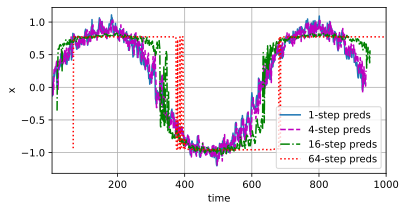

In [ ]:
# ==================== k步预测的可视化 ====================
# 探索不同预测步数的效果
# - 1步预测：用真实历史预测下一个
# - 4步预测：用3个真实值+1个预测值
# - 16步预测：大部分是预测值
# - 64步预测：几乎全是预测值

# 最大预测步数
max_steps = 64

# 创建扩展的特征矩阵
# 形状：(T - tau - max_steps + 1, tau + max_steps)
# 前tau列：真实观测值
# 后max_steps列：预测值（1步预测、2步预测、...、64步预测）
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 填充前tau列：真实观测值
# 这些列包含原始的时间序列数据
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 填充后max_steps列：k步预测
# 对于第i列（i >= tau）：
# - 使用前tau列作为输入
# - 进行(i - tau + 1)步预测
for i in range(tau, tau + max_steps):
    # 用前tau列的特征进行预测
    # features[:, i - tau:i]包含：
    #   - 真实观测值（如果i-tau到i都在前tau列）
    #   - 混合真实值和预测值（否则）
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

# 选择要可视化的步数
steps = (1, 4, 16, 64)

# 可视化不同k步预测的结果
# 比较：
# - 1步预测：非常准确（主要用真实值）
# - 4步预测：还比较准确
# - 16步预测：开始偏离
# - 64步预测：严重偏离，几乎是直线
# 
# 结论：
# - 预测步数越大，累积误差越大
# - 长期预测需要更复杂的模型（如RNN、LSTM）
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))